In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

### 데이터 분석 및 전처리

데이터 불러오기

In [260]:
#
rating_df = pd.read_csv(r'C:\Users\User\Desktop\새 폴더\u.data', sep='\t', header=None, names = ['userID', 'movieID', 'rating', 'timestemp'])[['userID', 'movieID', 'rating']]
rating_df


,userID,movieID,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [262]:
movie_info_df = pd.read_csv(r'C:\Users\User\Desktop\새 폴더\u.item', sep='|', encoding='latin')
movie_info_df.columns = ['movieID' , 'movie_title' , 'release_date' , 'video_release_date' ,
              'IMDb_URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Children' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
              'Thriller' , 'War' , 'Western']

데이터 준비
- sparse matrix (데이터가 너무 크기 때문에)
- 일반적으로 유저 아이디와 무비 아이디가 매끄럽게 연속적으로 나열되어 있지 않음(탈퇴, 순서 뒤죽박죽, 아이디에 기호 포함)
- id -> index 로 변경 필요 
    - 0번부터 시작
    - 중간에 비어 있는 게 없어야 함.

In [263]:
#apply(복잡한 처리, 룰이 있는 것) map(카테고리 데이터를 치환)
user_ids = rating_df['userID'].unique()
#mapping table = {id : index, ....}
user2idx_dict = {x : i for i, x in enumerate(user_ids)} #enumerate 사용해서 뒤엔 유저id 앞엔 인덱스

movie_ids = rating_df['movieID'].unique()
#mapping table = {id : index, ....}
movie2idx_dict = {x : i for i, x in enumerate(movie_ids)}

rating_df['u_idx'] = rating_df['userID'].map(user2idx_dict)
rating_df['i_idx'] = rating_df['movieID'].map(movie2idx_dict)

rating_df = rating_df.sort_values(['u_idx', 'i_idx']) #정렬
rating_df

,userID,movieID,rating,u_idx,i_idx
0,196,242,3,0,0
22773,196,257,2,0,10
10017,196,111,4,0,83
10981,196,25,4,0,86
35197,196,382,4,0,92
...,...,...,...,...,...
92090,941,300,4,942,652
99006,941,1007,4,942,672
69939,941,124,5,942,873
74458,941,993,4,942,935


추천시스템을 위한 데이터의 분포 조사(편향)

In [264]:
#영화별로 사람들이 얼마나 평가했는지
rating_count = rating_df.groupby('movieID').count()['userID'].sort_values(ascending = False)
rating_count

movieID
50      583
258     509
100     508
181     507
294     485
       ... 
1576      1
1577      1
1348      1
1579      1
1682      1
Name: userID, Length: 1682, dtype: int64

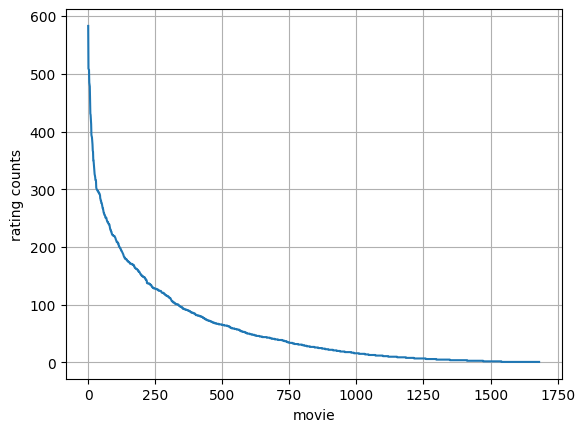

In [117]:
plt.plot(rating_count.to_list())
plt.xlabel('movie')
plt.ylabel('rating counts')
plt.grid()
plt.show()

sparse matrix 만들기
- data, row_index, col_index, shape
- (row, col)

In [265]:
num_user = rating_df['u_idx'].nunique()
num_movie = rating_df['i_idx'].nunique()

train, val , test data split 해야 함

In [266]:
from sklearn.model_selection import train_test_split
#어떤 비율로 나눌 것인가 고민 필요(6:2:2, 6:3:1, 7:2:1, 7:1.5:1.5)
#CF_기반 추천시스템 9:0.5:0.5
train_df, test_df = train_test_split(rating_df, test_size = 0.1, random_state = 1004)
val_df, test_df = train_test_split(test_df, test_size = 0.5, random_state = 1004)

In [259]:
test_df

,userID,movieID,rating,u_idx,i_idx
48242,186,38,5,1,543
97859,938,273,5,930,141
48799,567,124,4,565,873
1132,7,662,3,38,264
66528,554,531,4,551,333
...,...,...,...,...,...
63556,548,79,5,543,156
60783,836,875,1,827,570
72226,889,29,3,885,14
11822,37,22,5,237,408


In [267]:
from scipy.sparse import coo_matrix 
train_sp = coo_matrix((train_df['rating'], 
                (train_df['u_idx'], train_df['i_idx'])),
                shape = (num_user, num_movie))

train_sp


<943x1682 sparse matrix of type '<class 'numpy.int64'>'
	with 90000 stored elements in COOrdinate format>

모델 빌드 및 학습

In [268]:
knn = NearestNeighbors(n_neighbors= 50, metric = 'cosine')
knn.fit(train_sp)

NearestNeighbors(metric='cosine', n_neighbors=50)

결과 추론 및 평가

In [269]:
# target_user를 sp matrux   형태로 선언
target_user_idx = 8
target_tr_df = train_df[train_df['u_idx'] == target_user_idx]
target_sp = coo_matrix((target_tr_df['rating'],
                        ([0] * len(target_tr_df), target_tr_df['i_idx'])),
                        shape = (1, num_movie))

In [270]:
dist, idx = knn.kneighbors(target_sp, n_neighbors= 50)

In [239]:
dist

array([[0.        , 0.50633107, 0.51369616, 0.51953965, 0.51971038,
        0.52378343, 0.52452881, 0.53467548, 0.53579367, 0.53714239,
        0.54532484, 0.54685245, 0.54687104, 0.54782692, 0.54790311,
        0.55287978, 0.56093259, 0.56241147, 0.56278344, 0.56443476,
        0.56463025, 0.56465575, 0.56687907, 0.56700303, 0.56970768,
        0.57010652, 0.57040344, 0.57233254, 0.57235286, 0.57259434,
        0.57828037, 0.57845564, 0.57847139, 0.57938688, 0.57969024,
        0.58044763, 0.58095662, 0.58160852, 0.58166129, 0.58283363,
        0.58334616, 0.58402177, 0.58407507, 0.58472429, 0.58506896,
        0.58664096, 0.58675889, 0.58743511, 0.58828246, 0.58934206]])

In [240]:
idx

array([[  8, 114, 534, 907, 375, 129, 311, 556, 504, 658, 333, 406, 421,
        885, 467, 453,   9, 325,  68,  52, 118, 339, 743,  88, 531, 739,
        102,  10,  23,  83, 915, 814,  22,  58,  80, 340, 662, 842, 442,
        348, 867,  85, 193, 542,  65, 584, 446,  45, 831, 110]],
      dtype=int64)

In [271]:
# 8번 유저에 대한 이웃들의 영화 평점 예측
n_df = train_df[train_df['u_idx'].isin(idx[0][1:])]
pred_df  = n_df.groupby('movieID').mean()['rating'].sort_values(ascending =False)
pred_df = pred_df.reset_index()
pred_df.columns = ['movieID', 'pred']
pred_df

,movieID,pred
0,113,5.0
1,1643,5.0
2,1466,5.0
3,1512,5.0
4,814,5.0
...,...,...
1344,1165,1.0
1345,352,1.0
1346,907,1.0
1347,35,1.0


모델 평가

In [272]:
target_te_df = test_df[test_df['u_idx'] == target_user_idx]
# target_te_df.sort_values('movieID')
target_te_df.sort_values('rating')

,userID,movieID,rating,u_idx,i_idx
237,305,214,2,8,195
51934,305,89,3,8,217
97694,305,484,3,8,241
36389,305,184,3,8,373
36315,305,686,3,8,470
79892,305,59,3,8,574
5341,305,1101,4,8,677
8092,305,156,4,8,351


In [273]:
# pred_df[pred_df['movieID'].isin(target_te_df['movieID'])].sort_values('movieID')
pred_te_df = pred_df[pred_df['movieID'].isin(target_te_df['movieID'])].sort_values('pred')
pred_te_df

,movieID,pred
594,184,3.312500
531,214,3.466667
456,1101,3.550000
415,686,3.642857
256,156,3.925926
118,59,4.125000
60,484,4.291667
40,89,4.372093


In [274]:
#유저 한 명에 대해서 테스트
result_df = pd.merge(target_te_df, pred_te_df, on = 'movieID', how = 'inner')[['movieID', 'rating', 'pred']]
result_df 

,movieID,rating,pred
0,89,3,4.372093
1,484,3,4.291667
2,1101,4,3.550000
3,184,3,3.312500
4,156,4,3.925926
5,686,3,3.642857
6,214,2,3.466667
7,59,3,4.125000


- 평점은 조금 틀려보임(RMSE)
- 추천시스템의 평가는 top N개를 추천할 때 그게 맞느냐? Top1(0/1), Top2(2/2), Top3(2/3), Top4(3/4) 탑n개에 대한 정확한예측 Top@10 
- 순서를 잘 맞추냐 nDCG

전체 test 데이터에 있는 모든 데이터를 바탕으로 일반화 시켜보기

In [246]:
# total_pred_df = pd.DataFrame(data = None, columns = ['movieID', 'rating', 'pred'])
# total_pred_df 

,movieID,rating,pred


In [276]:
# target_user를 sp matrux   형태로 선언

total_pred_df = pd.DataFrame(data = None, columns = ['movieID', 'userID', 'rating', 'pred'])
for target_user_idx in range(num_user):
    target_tr_df = train_df[train_df['u_idx'] == target_user_idx]
    target_sp = coo_matrix((target_df['rating'],
                            ([0] * len(target_df), target_df['i_idx'])),
                            shape = (1, num_movie))

    dist, idx = knn.kneighbors(target_sp, n_neighbors= 50)

    n_df = rating_df[rating_df['u_idx'].isin(idx[0][1:])]
    pred_df  = n_df.groupby('movieID').mean()['rating'].sort_values(ascending =False)
    pred_df = pred_df.reset_index()
    pred_df.columns = ['movieID', 'pred']
    
    target_te_df = test_df[test_df['u_idx'] == target_user_idx]
    target_te_df.sort_values('rating')
    pred_te_df = pred_df[pred_df['movieID'].isin(target_te_df['movieID'])].sort_values('pred')
    
    result_df = pd.merge(target_te_df, pred_te_df, on = 'movieID', how = 'inner')[['movieID', 'userID', 'rating', 'pred']]
    
    total_pred_df = pd.concat([total_pred_df, result_df])

In [277]:
total_pred_df.head(10)

,movieID,userID,rating,pred
0,173,196,2,4.255814
1,251,196,3,4.666667
0,38,186,5,2.333333
1,306,186,4,4.000000
2,291,186,4,3.000000
3,98,186,5,4.297872
4,880,186,3,3.500000
5,1213,186,3,2.000000
6,829,186,4,2.500000
7,356,186,5,3.062500


In [278]:
import plotly.express as px

px.violin(total_pred_df, x = 'rating', y = 'pred', box =True)

In [279]:
#전체 RMSE 값 
from sklearn.metrics import mean_squared_error
mean_squared_error(total_pred_df['rating'], total_pred_df['pred'], squared = False)

1.1065275515939181

In [280]:
for i in range(1, 6):
    rmse = mean_squared_error(total_pred_df[total_pred_df['rating'] == i]['rating'],
                               total_pred_df[total_pred_df['rating'] == i]['pred'],
                                squared = False)
    print(i, rmse)

1 1.9897098473285506
2 1.2608806772011012
3 0.7772836478282501
4 0.8203680679688852
5 1.3780686406266023


In [285]:
good_df = total_pred_df[total_pred_df['rating'] > 3]
bad_df = total_pred_df[total_pred_df['rating'] < 3]

In [287]:
good_df['target_bool'] = 1
bad_df['target_bool'] = 0
cls_df = pd.concat([good_df, bad_df])
cls_df

C:\Users\User\AppData\Local\Temp\ipykernel_4872\2430273948.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_4872\2430273948.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,movieID,userID,rating,pred,target_bool
0,38,186,5,2.333333,1
1,306,186,4,4.000000,1
2,291,186,4,3.000000,1
3,98,186,5,4.297872,1
6,829,186,4,2.500000,1
...,...,...,...,...,...
1,325,926,1,2.142857,0
2,1067,943,2,3.500000,0
3,720,943,1,2.375000,0
2,535,936,2,2.666667,0


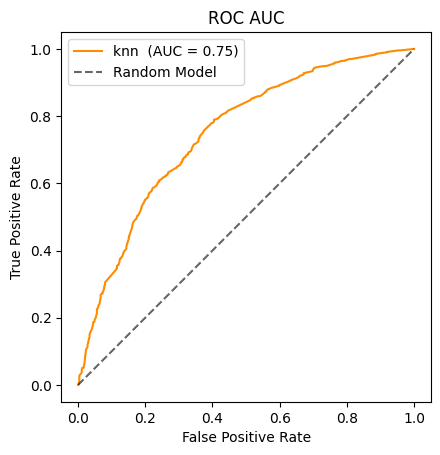

In [288]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    cls_df['target_bool'], #real
    (cls_df['pred'] - 1)/4, #pred prob
    name=f"knn ",
    color="darkorange",
)

plt.plot([0, 1], [0, 1], color='k', label='Random Model', linestyle = '--', alpha = 0.6)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC")
plt.legend()
plt.show()

In [296]:
from sklearn.metrics import classification_report

for thd in np.linspace(0.5, 4, 8):
    cls_df['pred_bool'] = cls_df['pred'].apply(lambda x : 1 if x > thd else 0)
    print('=' * 40)
    print(f'thd = {thd}')
    print(classification_report(cls_df['target_bool'],cls_df['pred_bool']))

thd = 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       821
           1       0.77      1.00      0.87      2797

    accuracy                           0.77      3618
   macro avg       0.39      0.50      0.44      3618
weighted avg       0.60      0.77      0.67      3618

thd = 1.0
              precision    recall  f1-score   support

           0       0.73      0.04      0.07       821
           1       0.78      1.00      0.87      2797

    accuracy                           0.78      3618
   macro avg       0.76      0.52      0.47      3618
weighted avg       0.77      0.78      0.69      3618

thd = 1.5
              precision    recall  f1-score   support

           0       0.73      0.08      0.14       821
           1       0.79      0.99      0.88      2797

    accuracy                           0.78      3618
   macro avg       0.76      0.53      0.51      3618
weighted avg       0.77      0.78      0.71 

c:\Users\User\anaconda3\envs\py39_test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\User\anaconda3\envs\py39_test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\User\anaconda3\envs\py39_test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



-------------------------------------------------------------------------------------------------------

matrix로 만들기 위해 빈공간을 제거하고 index를 새로 부여

In [93]:
user_ids = rating_df["userID"].unique().tolist()
random.shuffle(user_ids)
user2idx_dict = {x: i for i, x in enumerate(user_ids)}
idx2user_dict = {i: x for i, x in enumerate(user_ids)}

movie_ids = rating_df["movieID"].unique().tolist()
random.shuffle(movie_ids)
movie2idx_dict = {x: i for i, x in enumerate(movie_ids)}
idx2movie_dict = {i: x for i, x in enumerate(movie_ids)}

rating_df["new_u_idx"] = rating_df["userID"].map(user2idx_dict)
rating_df["new_i_idx"] = rating_df["movieID"].map(movie2idx_dict)

num_users = rating_df["userID"].nunique()
num_movies = rating_df["movieID"].nunique()
print(num_users, num_movies)

rating_df = rating_df.sort_values(['new_u_idx', 'new_i_idx'])
rating_df = rating_df.reset_index(drop=True)
rating_df

943 1682


,userID,movieID,rating,u_idx,i_idx,new_u_idx,new_i_idx
0,204,302,5,280,1,0,18
1,204,242,5,280,0,0,30
2,204,874,3,280,736,0,36
3,204,318,5,280,200,0,70
4,204,288,3,280,60,0,73
...,...,...,...,...,...,...,...
99995,934,157,2,927,740,942,1624
99996,934,96,4,927,102,942,1626
99997,934,65,4,927,203,942,1646
99998,934,286,4,927,289,942,1661


데이터 분포 조사

Text(0, 0.5, 'number of ratings')

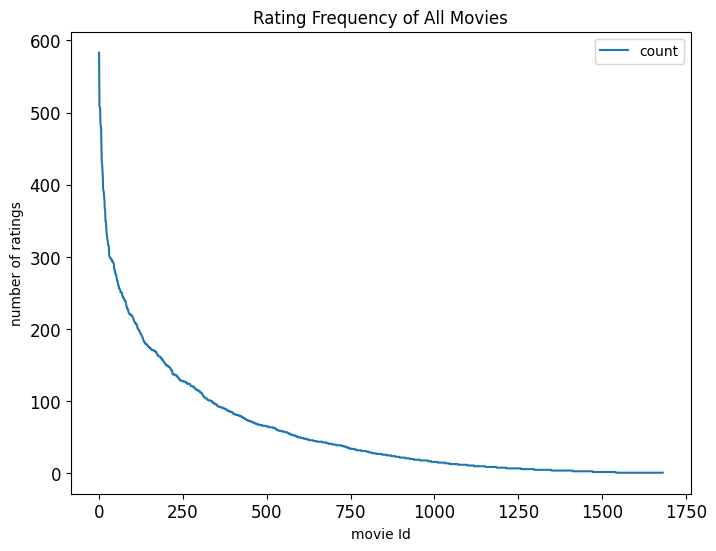

In [ ]:
movies_count_df = pd.DataFrame(rating_df.groupby('movieID').size(), columns=['count'])
movies_count_df.head()
ax = movies_count_df.sort_values('count', ascending=False) \
                    .reset_index(drop=True) \
                    .plot(
                        figsize=(8, 6),
                        title='Rating Frequency of All Movies',
                        fontsize=12
                    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

In [ ]:
num_users = rating_df['new_u_idx'].nunique()
num_movies = rating_df['new_i_idx'].nunique()
print(num_users, num_movies)

943 1682


In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=1004)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=1004)

In [ ]:
train_df

,userID,movieID,rating,timestamp,new_u_idx,new_i_idx
96120,907,628,5,880158986,915,614
91921,640,689,4,886353852,873,418
42605,488,207,3,891294942,417,1448
38525,887,143,5,881379781,377,772
88615,110,684,4,886988480,847,1186
...,...,...,...,...,...,...
79795,495,179,5,888632470,758,1379
42223,472,218,4,875980120,414,807
13637,263,197,4,891299752,133,511
86047,334,488,5,891546231,816,571


sparse data matrix 생성

In [ ]:
from scipy.sparse import coo_matrix
rating_sparse_arr = coo_matrix((train_df['rating'].to_list(),
                              (train_df['new_u_idx'].to_list(),
                              train_df['new_i_idx'].to_list())),
                             shape=(num_users, num_movies))

### model 빌드 및 학습

In [ ]:
knn_model = NearestNeighbors(n_neighbors = 50, metric='cosine', algorithm='brute')
knn_model.fit(rating_sparse_arr)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=50)

최근접 이웃 추론

In [ ]:
selected_usr_id = 500
get_single_user = rating_df[rating_df['new_u_idx'] == selected_usr_id]
get_single_user = coo_matrix((get_single_user['rating'].to_list(),
                              ([0]*len(get_single_user),
                              get_single_user['new_i_idx'].to_list())),
                             shape=(1, num_movies))

distances, indices = knn_model.kneighbors(get_single_user, n_neighbors=40)
cnt = 0
for d, i in zip(distances[0], indices[0]):
    print(f'{i} -  {d:.3f}')

    if cnt > 10:
        break
    cnt += 1

# 그래프 방식의 모델
# arr = knn_model.kneighbors_graph(get_single_user)
# for a in arr:
#     print(a)


500 -  0.027
374 -  0.414
46 -  0.444
544 -  0.491
623 -  0.504
78 -  0.521
10 -  0.522
794 -  0.524
283 -  0.530
659 -  0.537
427 -  0.541
227 -  0.558


평점 예측

In [ ]:
pred_df = rating_df[rating_df['new_u_idx'].isin(indices[0][1:])].groupby('movieID').agg('mean').sort_values('rating', ascending = False)['rating']
pred_df = pred_df.rename('pred')
pred_df = pred_df.reset_index()
pred_df

,movieID,pred
0,607,5.0
1,511,5.0
2,285,5.0
3,275,5.0
4,1293,5.0
...,...,...
228,908,1.0
229,341,1.0
230,1025,1.0
231,1671,1.0


### 모델 평가하기

In [ ]:
rating_result_df = pd.merge(single_test_df, pred_df, on = 'movieID', how='inner')
rating_result_df

,userID,movieID,rating,timestamp,new_u_idx,new_i_idx,pred
0,349,546,3,879466200,942,562,3.04


In [ ]:
total_pred_df = pd.DataFrame(data=None, columns=['new_u_idx', 'rating', 'pred'])
total_pred_df

,new_u_idx,rating,pred


In [ ]:
for selected_usr_id in range(num_users):
    get_single_user = rating_df[rating_df['new_u_idx'] == selected_usr_id]
    get_single_user = coo_matrix((get_single_user['rating'].to_list(),
                                ([0]*len(get_single_user),
                                get_single_user['new_i_idx'].to_list())),
                                shape=(1, num_movies))

    distances, indices = knn_model.kneighbors(get_single_user, n_neighbors=40)
    pred_df = rating_df[rating_df['new_u_idx'].isin(indices[0][1:])].groupby('movieID').agg('mean').sort_values('rating', ascending = False)['rating']
    pred_df = pred_df.rename('pred')
    pred_df = pred_df.reset_index()

    single_test_df = test_df[test_df.new_u_idx == selected_usr_id]
    rating_result_df = pd.merge(single_test_df, pred_df, on = 'movieID', how='inner')[['new_u_idx', 'rating', 'pred']]
    total_pred_df = pd.concat([total_pred_df, rating_result_df])
total_pred_df

,new_u_idx,rating,pred
0,0,3,3.100000
1,0,2,2.800000
2,0,1,3.230769
3,0,2,4.111111
4,0,2,2.800000
...,...,...,...
1,940,1,3.736842
2,940,2,4.000000
0,941,2,3.384615
1,941,4,3.655172


In [ ]:
import plotly.express as px
px.violin(total_pred_df, x='rating', y='pred', box=True)

In [ ]:
from sklearn.metrics import mean_squared_error
total_rmse = mean_squared_error(total_pred_df.rating, total_pred_df.pred, squared=False)
total_rmse

1.0202850684533553

In [ ]:
high_rmse = mean_squared_error(total_pred_df[total_pred_df.rating >= 4].rating, total_pred_df[total_pred_df.rating >= 4].pred, squared=False)
high_rmse

0.8760981511793955

In [ ]:
low_rmse = mean_squared_error(total_pred_df[total_pred_df.rating <= 2].rating, total_pred_df[total_pred_df.rating <= 2].pred, squared=False)
low_rmse

1.667919175409322

In [ ]:
total_pred_df['rating_bool'] = total_pred_df['rating'] > 3
total_pred_df['pred_bool'] = total_pred_df['pred'] > 3
total_pred_df

,new_u_idx,rating,pred,rating_bool,pred_bool
0,0,3,3.100000,False,True
1,0,2,2.800000,False,False
2,0,1,3.230769,False,True
3,0,2,4.111111,False,True
4,0,2,2.800000,False,False
...,...,...,...,...,...
1,940,1,3.736842,False,True
2,940,2,4.000000,False,True
0,941,2,3.384615,False,True
1,941,4,3.655172,True,True


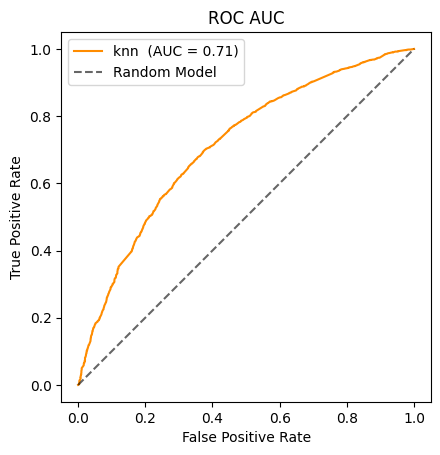

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    total_pred_df['rating_bool'],
    (total_pred_df['pred'] - 1)/4,
    name=f"knn ",
    color="darkorange",
)

plt.plot([0, 1], [0, 1], color='k', label='Random Model', linestyle = '--', alpha = 0.6)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC")
plt.legend()
plt.show()